In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import copy
import ipython_bell

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 46 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
# Color distribution
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
colors = pd.read_csv(path + 'color_distribution/source_colors.csv')
colors = colors[colors['DNF_ZMEAN_MOF'] > 0.01] #When there is no data z<0
colors = colors[colors['MAG_PSF_G'] < 30.] [colors['MAG_PSF_R'] < 30.] [colors['MAG_PSF_I'] < 30.] #decent magnitude
colors['g_r'] = colors['MAG_PSF_G'] - colors['MAG_PSF_R'] # g-r color
colors['r_i'] = colors['MAG_PSF_R'] - colors['MAG_PSF_I'] # r-i color

dz = 0.1 # Range of redshift for filtering
dm = 0.2 # Range of magnitude for filtering

def magnitude_and_color_distribution(z, mmin = 20, mmax = 26):
    #objects with a redshift between z - dz and z + dz, same idea for apparent magnitude
    fcolors = colors[(colors['DNF_ZMEAN_MOF'] > z - dz)] [(colors['DNF_ZMEAN_MOF'] < z + dz)] 
    #getting a realistic magnitude for this redshift
    m = fcolors.sample()['MAG_PSF_G'].values[0]
    while(m > mmax or m < mmin):
        m = fcolors.sample()['MAG_PSF_G'].values[0]
    fcolors = fcolors[(colors['MAG_PSF_G'] > m - dm)] [(colors['MAG_PSF_G'] < m + dm)]
    random_object = fcolors.sample()
    m = random_object['MAG_PSF_G'].values[0]
    g_r = random_object['g_r'].values[0]
    r_i = random_object['r_i'].values[0]
    return(m, g_r, r_i)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [4]:
def simulation(redshifts, sigma, lens_ellip, magnitudes, double, i, cut_E, c):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source2']
                            } 
                           #and also serves as the redshift of lensed point sources}
        
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': sigma, 'center_x': 0, 'center_y': 0, 
                    'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #lens light distribution
    m_lens, g_r_lens, r_i_lens =  magnitude_and_color_distribution(redshifts['lens'], mmin = 18, mmax = 27)
    m_lens = 22
    kwargs_lens_light_mag_g = [{'magnitude': m_lens, 'R_sersic': .7, 'n_sersic': 2, 'e1': 0., 'e2': 0., 
                                'center_x': 0, 'center_y': 0}]
    
    #First source light distributions & colors of the other bands for each source
    m1, g_r_source_1, r_i_source_1 = magnitude_and_color_distribution(redshifts['source1'], mmin = magnitudes['m1_min'], mmax = magnitudes['m1_max1'])
    r1, n1 = random.uniform(0.2, 0.4), random.uniform(1.2, 1.7)
    m1 = 40
    kwargs_source_mag_g = [{'magnitude': m1, 'R_sersic': r1, 'n_sersic': n1, 'e1': 0., 'e2': 0.,
                              'center_x': 0, 'center_y': 0}]
    #Adding color distribution to the bands (lens):
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_r)
    kwargs_lens_light_mag_i[0]['magnitude'] -= r_i_lens
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_r)
        
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_g, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_r, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_i, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    image_g = image_g[::-1]
    image_r = image_r[::-1]
    image_i = image_i[::-1] 
    
    #"""
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    plt.figure()
    plt.imshow(rgb)
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.savefig('Image' + str(i) + '.png', bbox_inches='tight')
    plt.show(block=True)
    #plt.close()
    #"""

In [5]:
complete_data = pd.read_csv(path + 'Data/all_data_sim.csv')
print(len(complete_data))
data = complete_data.sample(n = 500, replace = True) 
data.head(2)

19727


,COADD_OBJECT_ID,PIXEL,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I
12807,353238024,74596116,19.749999,4.541694,-0.090385,-0.136806,0.449653,169.68651,1.17483,0.963758,0.844905
15143,351858749,73615735,12.586134,-2.935863,-0.124448,-0.143445,0.504106,219.59053,1.10036,1.013500,0.913180


In [6]:
def simulations_from_data(num_max, double):
    complete_data = pd.read_csv(path + 'Data/all_data_sim.csv')
    data = complete_data.sample(frac=1).reset_index() #(n = 30000, replace = True)
    for index, row in data.iterrows():
        if index == num_max:
            break
        DES_g_band_obs['seeing'] = row['FWHM_WMEAN_G'] 
        DES_r_band_obs['seeing'] = row['FWHM_WMEAN_R']
        DES_i_band_obs['seeing'] = row['FWHM_WMEAN_I']
        
        coadd_id = int(row['COADD_OBJECT_ID'])
        z_lens = row['Z']
        z_source1 = random.uniform(z_lens, z_lens + 0.7) # 0.35, 0.7
        z_source2 = random.uniform(z_source1, z_source1 + 0.35) # 0.35
        redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
        dispersion = row['VEL_DISP']
        #m1_max random:
        magnitudes = {'m1_min': 20., 'm1_max1':25.8, 'm2_max':26} #23.9, 26
        c = 0.9
        cut_E = 0.4
    
        angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
        angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
        ratio = random.uniform(0.001, 1) #distribution for the axis ratio
        e1, e2 = param.phi_q2_ellipticity(angle, ratio)
        lens_ellip = [e1, e2]
    
        simulation(redshifts, dispersion, lens_ellip, magnitudes, double , coadd_id, cut_E, c)


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in log10


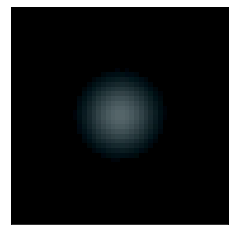

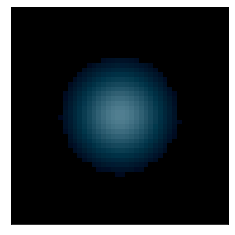

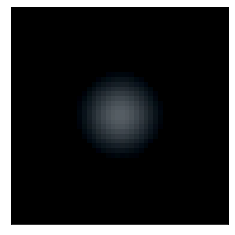

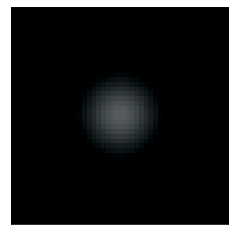

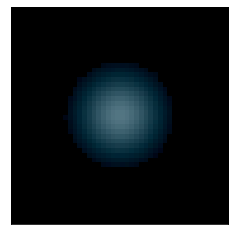

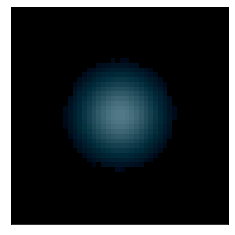

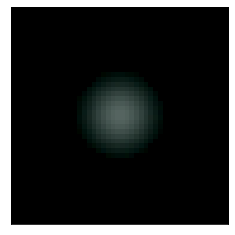

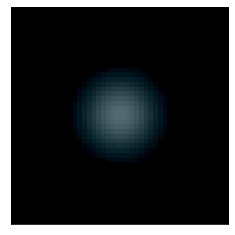

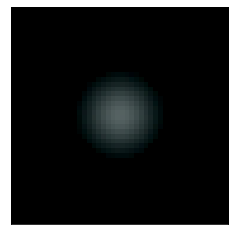

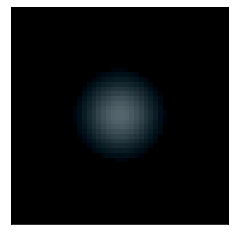

In [7]:
simulations_from_data(10, False)